In [1]:
import pandas as pd
import glob
import os
import torch

from collections import defaultdict

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
files = glob.glob('../data/preprocessed/*.pt')
len(files)

0

In [35]:
from tqdm import tqdm

meta = defaultdict(list)
for f in tqdm(files):
    pid = os.path.basename(f).split('.')[0]
    data = torch.load(f'../data/preprocessed/{pid}.pt')
    
    if len(data['aa_idx']) != len(data['node_angle_feat']):
        continue
        
    if len(data['aa_idx']) != len(data['node_dir_feat']):
        continue
        
    meta['id'].append(pid)
    meta['num_residues'].append( len(data['aa_idx']) )
    
meta = pd.DataFrame(meta)

100%|██████████| 30685/30685 [00:27<00:00, 1112.66it/s]


In [38]:
meta[meta.num_residues >= 31].to_csv('../data/meta.csv', index=False)

### GVP-CATH

In [45]:
files = glob.glob('../data/gvp_preprocessed/*.pt')
len(files)

21667

In [46]:
from tqdm import tqdm

meta = defaultdict(list)
for f in tqdm(files):
    pid = os.path.basename(f).split('.')[0]
    data = torch.load(f'../data/gvp_preprocessed/{pid}.pt')
    
    if len(data['aa_idx']) != len(data['node_angle_feat']):
        continue
        
    if len(data['aa_idx']) != len(data['node_dir_feat']):
        continue
        
    meta['id'].append(pid)
    meta['num_residues'].append( len(data['aa_idx']) )
    
meta = pd.DataFrame(meta)

100%|██████████| 21667/21667 [00:28<00:00, 769.20it/s]


In [53]:
import json

with open('../data/gvp-data/chain_set_splits.json') as inFile:
    splits = json.loads(inFile.read())
    
train, val, test = set(splits['train']), set(splits['validation']), set(splits['test'])
train = {id.replace('.', '_') for id in train}
val = {id.replace('.', '_') for id in val}
test = {id.replace('.', '_') for id in test}

In [51]:
len(train), len(val), len(test)

(18024, 608, 1120)

In [54]:
meta['is_train'] = meta['id'].isin(train)
meta['is_val'] = meta['id'].isin(val)
meta['is_test'] = meta['id'].isin(test)

In [60]:
meta[meta.is_train].to_csv('../data/meta.gvp_train.csv', index=False)
meta[meta.is_val].to_csv('../data/meta.gvp_val.csv', index=False)
meta[meta.is_test].to_csv('../data/meta.gvp_test.csv', index=False)

In [45]:
train = pd.read_csv('../data/meta.gvp_train.csv')
val = pd.read_csv('../data/meta.gvp_val.csv')
test = pd.read_csv('../data/meta.gvp_test.csv')

<AxesSubplot: >

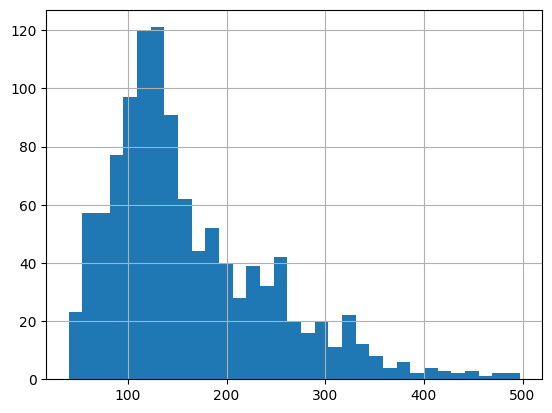

In [19]:
test['num_residues'].hist(bins=33)

<AxesSubplot: >

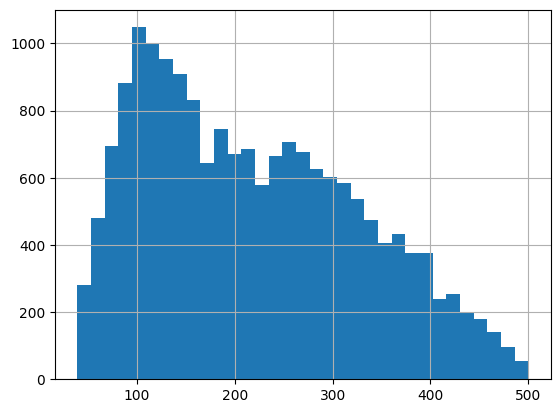

In [20]:
train['num_residues'].hist(bins=33)

In [42]:
import numpy as np
max_num_residues = train['num_residues'].max()
train['bin'] = pd.cut(train['num_residues'], bins=np.linspace(0, max_num_residues, 10))
train['p_sample'] = 1 / train['bin'].map(train['bin'].value_counts()).astype(int)
train = train.drop('bin', axis=1)

In [43]:
train.head(3)

,id,num_residues,is_train,is_val,is_test,p_sample
0,2xw7_A,175,True,False,False,0.000368
1,1wxw_A,377,True,False,False,0.000605
2,3f5c_B,183,True,False,False,0.000368


In [44]:
train.to_csv('../data/meta.gvp_train.csv', index=False)

In [40]:
train.p_sample.value_counts()

0.000280    3568
0.000308    3251
0.000368    2721
0.000386    2593
0.000427    2341
0.000605    1653
0.000936    1068
0.002123     471
0.002793     358
Name: p_sample, dtype: int64